# EDS220: Assignment 4, Task 2
## False Color Images

**Author:** Sofia Sarak

**Github repository:** https://github.com/sofiasarak/eds220-hwk4

In [5]:
import os
import geopandas as gpd
import xarray as xr

### 2. Fire Perimeter Data Exploration

The following data set was sourced from [LA County's GIS hub](https://egis-lacounty.hub.arcgis.com/maps/ad51845ea5fb4eb483bc2a7c38b2370c/about). It contains dissolved fire perimeters/boundaries for Eaton and Palisades fires. It is a public data set, published January 21, 2025 and last updated on February 26, 2025

In [6]:
# Read in data, using os to build file path and geopandas to read in .shp file
fp = os.path.join('data','Eaton_Perimeter_20250121','Eaton_Perimeter_20250121.shp')
perimeter = gpd.read_file(fp)

<Axes: >

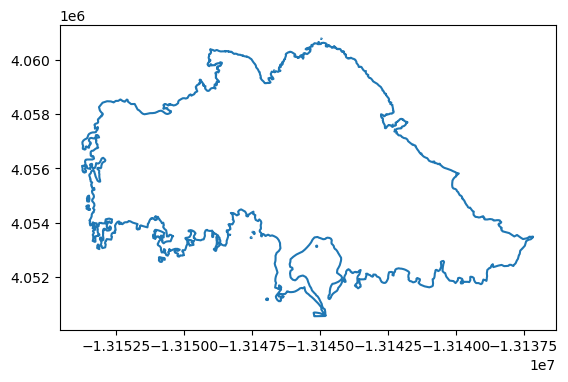

In [7]:
# Plot perimeter data to visualize its contents
perimeter.boundary.plot()

In [8]:
# What is the CRS?
print(f"The CRS of our fire perimeter data is {perimeter.crs}.")

The CRS of our fire perimeter data is EPSG:3857.


In [9]:
# Is it projected or geographic?
print(f"The CRS of perimeter data is projected? {perimeter.crs.is_projected}")
print(f"The CRS of periemeter data is geographic? {perimeter.crs.is_geographic}")

The CRS of perimeter data is projected? True
The CRS of periemeter data is geographic? False


#### Summary

From our exploration, we have determined the following:
1. Our perimeter data frame plots as one polygon object, from which we can extract just the boundary.
2. The CRS of our data is EPSG:3857.
3. The CRS is projected, not geographic.

### 3. Landsat (NetCDF) Data Import and Exploration

This data is sourced from the [Microsoft Planetary Computer catalogue](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2) and clipped to an area surrounding the fire perimeters. It contains a simplified collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data, collected by the Landsat 8 satellite.

In [37]:
# Read in data, using os to build file path
fp = os.path.join('data', 'landsat8-2025-02-23-palisades-eaton.nc')

# a. Import landsat data using `xr.open_dataset()`
landsat = xr.open_dataset(fp, engine="netcdf4")

In [11]:
# View first five rows of landsat data frame
landsat.head()

<xarray.Dataset> Size: 596B
Dimensions:      (y: 5, x: 5)
Coordinates:
  * y            (y) float64 40B 3.799e+06 3.799e+06 ... 3.799e+06 3.799e+06
  * x            (x) float64 40B 3.344e+05 3.344e+05 ... 3.345e+05 3.345e+05
    time         datetime64[ns] 8B ...
Data variables:
    red          (y, x) float32 100B ...
    green        (y, x) float32 100B ...
    blue         (y, x) float32 100B ...
    nir08        (y, x) float32 100B ...
    swir22       (y, x) float32 100B ...
    spatial_ref  int64 8B ...

In [ ]:
# What/how are the coordinates stored?
landsat.coords

Coordinates:
  * y        (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x        (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time     datetime64[ns] 8B ...

In [ ]:
# Dimensions
landsat.dims

FrozenMappingWarningOnValuesAccess({'y': 1418, 'x': 2742})

In [ ]:
# Data types
landsat.dtypes

Frozen({'red': dtype('float32'), 'green': dtype('float32'), 'blue': dtype('float32'), 'nir08': dtype('float32'), 'swir22': dtype('float32'), 'spatial_ref': dtype('int64')})

#### e. Summary 

From our preliminary exploration, we have determined the following:
1. `landsat` contains three kinds of coordinates: x, y (stored as floats), and time (stored as a datetime object).
2. The data variables are `red`, `green`, `blue`, `nir08`, and `swir22`, all stored as floats. These are the different bands of light that this data set stores information on. There is also another variable called `spatial_ref`, most likely storing geographic information (and is stored as an integer).
3. The x coordinate is 2742 values long and the y coordinate is 1418 values long.

### 4. Restoring geospatial information

In [ ]:
# a. CRS of landsat
print(landsat.rio.crs)

None


According to `.rio.crs`, this data set does not have a CRS. It appears that it may not automatically load as a geospatial object in Python.

There is however a variable called `spatial_ref`, which may contian the spatial information we are looking for.

In [ ]:
# b. Access crs through `spatial_ref` variable
crs = landsat.spatial_ref.crs_wkt
print(crs)

PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]


In order to transfrom the `landsat` data set into a geospatial object, we can use what is stored in the `spatial_ref` column to assign it a CRS.

In [34]:
# c. Recover and reassign geospatial info through .write_crs
landsat_geo = landsat.rio.write_crs(crs)

In [36]:
# d. Print new CRS info
print(landsat_geo.rio.crs)

EPSG:32611


### 5. True color image